## GNN-ASTGCN training on NOAA weather data

### Imports

In [1]:
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.attention import ASTGCN
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from math import radians, sin, cos, atan2, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Data

In [2]:
df_nodes = pd.read_csv("df_nodes.csv")  
df_events = pd.read_csv("df_events.csv", parse_dates=['DATE']) 

# Station IDs in a consistent order
unique_ids = df_nodes['ID'].unique().tolist()
num_nodes = len(unique_ids)
id_to_idx = {sid: i for i, sid in enumerate(unique_ids)}

df_events['node_idx'] = df_events['ID'].map(id_to_idx)
df_events.sort_values(['node_idx','DATE'], inplace=True)

### Build adjacency gaussian kernel from distances

In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    d_lat = radians(lat2 - lat1)
    d_lon = radians(lon2 - lon1)
    a = (sin(d_lat/2)**2) + cos(radians(lat1)) * cos(radians(lat2)) * (sin(d_lon/2)**2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def spatial_distance(row1, row2):
    dist_2d = haversine_distance(row1['LATITUDE'], row1['LONGITUDE'],
                                 row2['LATITUDE'], row2['LONGITUDE'])
    elev_diff = abs(row1['ELEVATION'] - row2['ELEVATION']) / 1000.0
    return dist_2d + elev_diff

coords = df_nodes[['LATITUDE','LONGITUDE','ELEVATION']].values
dist_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)
for i in range(num_nodes):
    for j in range(num_nodes):
        if i == j:
            dist_matrix[i, j] = 0.0
        else:
            dist_matrix[i, j] = spatial_distance(df_nodes.iloc[i], df_nodes.iloc[j])

sigma = np.std(dist_matrix)
adj_matrix = np.exp(-np.square(dist_matrix) / (2 * sigma**2))

# Convert adjacency to edge_index, edge_weight
def adjacency_to_edge_index(adj):
    edge_index = []
    edge_weight = []
    n = adj.shape[0]
    for i in range(n):
        for j in range(n):
            val = adj[i, j]
            if val > 0 and i != j:
                edge_index.append([i, j])
                edge_weight.append(val)
    edge_index = torch.LongTensor(edge_index).t().contiguous()
    edge_weight = torch.FloatTensor(edge_weight)
    return edge_index, edge_weight

edge_index, edge_weight = adjacency_to_edge_index(adj_matrix)

### Create feature array + day-of-year for seasonality

In [4]:
# features = ['PRCP','SNOW','SNWD','TMAX','TMIN']  # 5 weather features
features = ['PRCP','TMAX','TMIN'] # simplify to 3, but show notes below for 5 features

# Collect unique sorted dates
all_dates = df_events['DATE'].sort_values().unique()
all_dates = pd.to_datetime(all_dates)  # ensure DateTimeIndex
all_dates_list = list(all_dates)
date_to_idx = {dt: i for i, dt in enumerate(all_dates_list)}
T = len(all_dates_list)

num_feats = len(features)

# We will add 1 additional feature => day_of_year_fraction
# so final dimension: num_feats + 1 for day_of_year
X_array = np.zeros((T, num_nodes, num_feats + 1), dtype=np.float32)  # +1 for day_of_year

# Prepopulate the 5 weather features
for row in df_events.itertuples():
    t_index = date_to_idx[row.DATE]
    n_index = row.node_idx
    X_array[t_index, n_index, 0] = row.PRCP
    X_array[t_index, n_index, 1] = row.TMAX
    X_array[t_index, n_index, 2] = row.TMIN

# Build day-of-year fraction
# day_of_year in [1..365] (ignoring leap day or you can handle it as you like)
for i, dt in enumerate(all_dates_list):
    doy = dt.timetuple().tm_yday  # integer day-of-year
    # Simple fraction in [1..365] => scale by 365
    doy_fraction = doy / 365.0
    # replicate across all stations
    X_array[i, :, 3] = doy_fraction  # the new 6th feature

# So now each snapshot has shape [num_nodes, 6 features]

### Scale the sensor features, keep day_of_year separate

In [5]:
# We'll scale only the weather features and keep day_of_year in [0..1].
X_weather_flat = X_array[:, :, :3].reshape(-1, 3)  # shape [T*N, 5]
scaler = StandardScaler()
X_weather_scaled = scaler.fit_transform(X_weather_flat)
X_weather_scaled = X_weather_scaled.reshape(T, num_nodes, 3)

# Overwrite the weather columns in X_array
X_array[:, :, :3] = X_weather_scaled

### Build multi-step forecast dataset

In [6]:
HORIZON = 2 # 7 days forecast
WINDOW_IN = 6  # 14 input window
X_list = []
Y_list = []

max_t = T - HORIZON  # we need at least 7 future days
for t in range(max_t):
    # X_list[t] => single snapshot [num_nodes, 6]
    X_list.append(X_array[t])
    
    # Y_list[t] => next 7 days => shape [7, num_nodes, 6], but we only want to
    # predict the 5 weather features. However, for consistent shape,
    # let's keep all 6. Or you can skip day_of_year in the target if you prefer.
    # We'll keep all 6 for illustration, but often you'd exclude the seasonal feature from the direct target.
    fut_slice = X_array[t+1 : t+1 + HORIZON]  # => [7, num_nodes, 6]
    # reorder to [num_nodes, 6, 7]
    fut_slice = np.transpose(fut_slice, (1, 2, 0))
    Y_list.append(fut_slice)

dataset = StaticGraphTemporalSignal(
    edge_index=edge_index,
    edge_weight=edge_weight,
    features=X_list,  # each [num_nodes, 6]
    targets=Y_list    # each [num_nodes, 6, 7]
)

dataset_length = dataset.snapshot_count  # = T - HORIZON
train_len = int(0.7 * dataset_length)
val_len   = int(0.15 * dataset_length)
test_len  = dataset_length - train_len - val_len

train_indices = range(0, train_len)
val_indices   = range(train_len, train_len + val_len)
test_indices  = range(train_len + val_len, dataset_length)

### Define an ASTGCN model

In [7]:
class MyASTGCNWrapper(nn.Module):
    """
    Wrap ASTGCN so that final output: [B, N, out_channels, horizon].
    We'll set out_channels = 6 (same as in_channels) if we are
    forecasting all features, including the day_of_year feature.
    Typically, you'd want only the 5 weather features, but we'll keep 6 for a direct 1:1 mapping.
    """
    def __init__(self, num_nodes, in_channels=6, out_channels=6, horizon=7, window_in=14):
        super(MyASTGCNWrapper, self).__init__()
        
        self.astgcn = ASTGCN(
            nb_block=2, #2
            in_channels=in_channels,  
            K=3, #3                    
            nb_chev_filter=16, 
            nb_time_filter=16,
            time_strides=1,
            num_for_predict=horizon,   # 7
            len_input=window_in,       # 14
            num_of_vertices=num_nodes,
            normalization='sym',
            bias=True
        )
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.horizon = horizon
        
        # ASTGCN => [B, N, horizon]
        # We'll do a linear to map horizon -> out_channels*horizon
        self.proj = nn.Linear(horizon, out_channels*horizon)

    def forward(self, x, edge_index):
        # x: [B, N, F, T_in=14]
        out = self.astgcn(x, edge_index)  # => [B, N, horizon]
        
        B, N, H = out.shape  # horizon=H=7
        out = self.proj(out) # => [B, N, out_channels*horizon]
        out = out.view(B, N, self.out_channels, self.horizon)
        # => [B, N, out_channels=6, horizon=7]
        return out

model_wrapper = MyASTGCNWrapper(num_nodes=num_nodes, in_channels=4, out_channels=4,
    horizon=HORIZON, window_in=WINDOW_IN).to(device)

### Training utilities

In [8]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_wrapper.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

# Track losses by iteration
train_iteration_losses = []
val_iteration_losses = []

def train_one_epoch_old(model, optimizer, criterion, train_indices, window_in=14):
    model.train()
    total_loss = 0
    count = 0
    
    with tqdm(train_indices, desc="Training", unit="step") as pbar:
        for t in pbar:
            if t < window_in:
                continue
            
            # Build input window
            x_stack = []
            for past_t in range(t - window_in, t):
                x_in = dataset[past_t].x  # shape [N, 6]
                if isinstance(x_in, torch.Tensor):
                    x_in = x_in.cpu().numpy()
                x_stack.append(x_in)
            x_stack = np.stack(x_stack, axis=-1)  # => [N, 6, 14]
            
            x_torch = torch.from_numpy(x_stack).float().to(device)
            x_torch = x_torch.unsqueeze(0)  # => [1, N, 6, 14]
            
            data = dataset[t]
            y_true = data.y  # => [N, 6, 7]
            if isinstance(y_true, torch.Tensor):
                y_true = y_true.cpu().numpy()
            y_true = torch.from_numpy(y_true).float().to(device)
            y_true = y_true.unsqueeze(0)  # => [1, N, 6, 7]
            
            e_idx = data.edge_index.to(device)
            
            optimizer.zero_grad()
            y_pred = model(x_torch, e_idx)  # => [1, N, 6, 7]
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            count += 1
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
    
    return total_loss / max(count, 1)

gscaler = torch.amp.GradScaler()
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

def train_one_epoch(model, optimizer, criterion, train_indices, window_in=14):
    model.train()
    total_loss = 0
    count = 0
    
    with tqdm(train_indices, desc="Training", unit="step") as pbar:
        for t in pbar:
            if t < window_in:
                continue
            
            # Build input window
            x_stack = []
            for past_t in range(t - window_in, t):
                x_in = dataset[past_t].x
                if isinstance(x_in, torch.Tensor):
                    x_in = x_in.cpu().numpy()
                x_stack.append(x_in)
            x_stack = np.stack(x_stack, axis=-1)  # => [N, F, 14]

            x_torch = torch.from_numpy(x_stack).float().to(device).unsqueeze(0)  # => [1, N, F, 14]

            data = dataset[t]
            y_true = data.y
            if isinstance(y_true, torch.Tensor):
                y_true = y_true.cpu().numpy()
            y_true = torch.from_numpy(y_true).float().to(device).unsqueeze(0)  # => [1, N, F, 7]

            e_idx = data.edge_index.to(device)

            optimizer.zero_grad()

            # ----- AMP Block -----
            with torch.amp.autocast(device_type='cuda', dtype=ptdtype):
                y_pred = model(x_torch, e_idx)
                loss = criterion(y_pred, y_true)

            # Instead of loss.backward(), we do:
            gscaler.scale(loss).backward()

            # Instead of optimizer.step(), we do:
            gscaler.step(optimizer)
            gscaler.update()

            total_loss += loss.item()
            train_iteration_losses.append(loss.item())
            count += 1
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
    
    return total_loss / max(count, 1)

@torch.no_grad()
def evaluate(model, criterion, val_indices, window_in=14):
    model.eval()
    total_loss = 0
    count = 0
    
    with tqdm(val_indices, desc="Validation", unit="step") as pbar:
        for t in pbar:
            if t < window_in:
                continue
            
            x_stack = []
            for past_t in range(t - window_in, t):
                x_in = dataset[past_t].x
                if isinstance(x_in, torch.Tensor):
                    x_in = x_in.cpu().numpy()
                x_stack.append(x_in)
            x_stack = np.stack(x_stack, axis=-1)
            
            x_torch = torch.from_numpy(x_stack).float().to(device).unsqueeze(0)
            
            data = dataset[t]
            y_true = data.y
            if isinstance(y_true, torch.Tensor):
                y_true = y_true.cpu().numpy()
            y_true = torch.from_numpy(y_true).float().to(device).unsqueeze(0)
            
            e_idx = data.edge_index.to(device)
            
            y_pred = model(x_torch, e_idx)
            loss = criterion(y_pred, y_true)
            total_loss += loss.item()
            val_iteration_losses.append(loss.item())
            count += 1
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
    
    return total_loss / max(count, 1)

### Training Loop

In [9]:
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")
    
    train_loss = train_one_epoch(model_wrapper, optimizer, criterion, train_indices, WINDOW_IN)
    print(f"Train Loss: {train_loss:.4f}")
    
    val_loss = evaluate(model_wrapper, criterion, val_indices, WINDOW_IN)
    print(f"Val   Loss: {val_loss:.4f}")
    
    scheduler.step(val_loss)
    print("=" * 50)

# Save the model
model_save_path = "astgcn_model_3.pth"
torch.save(model_wrapper.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/20


Training: 100%|██████████| 1292/1292 [02:01<00:00, 10.59step/s, Loss=1.5445]


Train Loss: 0.8587


Validation: 100%|██████████| 276/276 [00:11<00:00, 25.06step/s, Loss=0.5932]


Val   Loss: 0.7456
Epoch 2/20


Training: 100%|██████████| 1292/1292 [01:58<00:00, 10.92step/s, Loss=1.2227]


Train Loss: 0.7488


Validation: 100%|██████████| 276/276 [00:10<00:00, 25.35step/s, Loss=0.5002]


Val   Loss: 0.6551
Epoch 3/20


Training: 100%|██████████| 1292/1292 [01:59<00:00, 10.79step/s, Loss=0.9872]


Train Loss: 0.6436


Validation: 100%|██████████| 276/276 [00:10<00:00, 27.27step/s, Loss=0.4274]


Val   Loss: 0.5848
Epoch 4/20


Training: 100%|██████████| 1292/1292 [01:57<00:00, 11.00step/s, Loss=0.8275]


Train Loss: 0.5636


Validation: 100%|██████████| 276/276 [00:10<00:00, 25.18step/s, Loss=0.3806]


Val   Loss: 0.5318
Epoch 5/20


Training: 100%|██████████| 1292/1292 [02:00<00:00, 10.73step/s, Loss=0.7146]


Train Loss: 0.5027


Validation: 100%|██████████| 276/276 [00:10<00:00, 26.45step/s, Loss=0.3486]


Val   Loss: 0.4916
Epoch 6/20


Training: 100%|██████████| 1292/1292 [01:59<00:00, 10.84step/s, Loss=0.6411]


Train Loss: 0.4559


Validation: 100%|██████████| 276/276 [00:11<00:00, 24.81step/s, Loss=0.3304]


Val   Loss: 0.4606
Epoch 7/20


Training: 100%|██████████| 1292/1292 [01:57<00:00, 11.00step/s, Loss=0.6080]


Train Loss: 0.4242


Validation: 100%|██████████| 276/276 [00:10<00:00, 25.94step/s, Loss=0.3232]


Val   Loss: 0.4410
Epoch 8/20


Training: 100%|██████████| 1292/1292 [01:58<00:00, 10.92step/s, Loss=0.6009]


Train Loss: 0.4063


Validation: 100%|██████████| 276/276 [00:12<00:00, 22.54step/s, Loss=0.3222]


Val   Loss: 0.4308
Epoch 9/20


Training: 100%|██████████| 1292/1292 [01:54<00:00, 11.25step/s, Loss=0.6000]


Train Loss: 0.3972


Validation: 100%|██████████| 276/276 [00:11<00:00, 23.25step/s, Loss=0.3224]


Val   Loss: 0.4254
Epoch 10/20


Training: 100%|██████████| 1292/1292 [02:01<00:00, 10.68step/s, Loss=0.5999]


Train Loss: 0.3918


Validation: 100%|██████████| 276/276 [00:12<00:00, 22.25step/s, Loss=0.3226]


Val   Loss: 0.4216
Epoch 11/20


Training: 100%|██████████| 1292/1292 [01:53<00:00, 11.34step/s, Loss=0.5989]


Train Loss: 0.3882


Validation: 100%|██████████| 276/276 [00:11<00:00, 23.95step/s, Loss=0.3221]


Val   Loss: 0.4189
Epoch 12/20


Training: 100%|██████████| 1292/1292 [01:58<00:00, 10.89step/s, Loss=0.5972]


Train Loss: 0.3854


Validation: 100%|██████████| 276/276 [00:10<00:00, 25.25step/s, Loss=0.3222]


Val   Loss: 0.4171
Epoch 13/20


Training: 100%|██████████| 1292/1292 [01:54<00:00, 11.33step/s, Loss=0.5956]


Train Loss: 0.3832


Validation: 100%|██████████| 276/276 [00:11<00:00, 23.47step/s, Loss=0.3220]


Val   Loss: 0.4153
Epoch 14/20


Training: 100%|██████████| 1292/1292 [01:59<00:00, 10.84step/s, Loss=0.5941]


Train Loss: 0.3815


Validation: 100%|██████████| 276/276 [00:11<00:00, 25.02step/s, Loss=0.3220]


Val   Loss: 0.4139
Epoch 15/20


Training: 100%|██████████| 1292/1292 [01:55<00:00, 11.18step/s, Loss=0.5933]


Train Loss: 0.3802


Validation: 100%|██████████| 276/276 [00:11<00:00, 25.07step/s, Loss=0.3215]


Val   Loss: 0.4130
Epoch 16/20


Training: 100%|██████████| 1292/1292 [01:59<00:00, 10.84step/s, Loss=0.5921]


Train Loss: 0.3791


Validation: 100%|██████████| 276/276 [00:10<00:00, 26.64step/s, Loss=0.3218]


Val   Loss: 0.4122
Epoch 17/20


Training: 100%|██████████| 1292/1292 [01:55<00:00, 11.20step/s, Loss=0.5910]


Train Loss: 0.3782


Validation: 100%|██████████| 276/276 [00:10<00:00, 26.08step/s, Loss=0.3232]


Val   Loss: 0.4120
Epoch 18/20


Training: 100%|██████████| 1292/1292 [01:58<00:00, 10.88step/s, Loss=0.5901]


Train Loss: 0.3775


Validation: 100%|██████████| 276/276 [00:10<00:00, 27.02step/s, Loss=0.3239]


Val   Loss: 0.4119
Epoch 19/20


Training: 100%|██████████| 1292/1292 [01:55<00:00, 11.16step/s, Loss=0.5892]


Train Loss: 0.3769


Validation: 100%|██████████| 276/276 [00:11<00:00, 24.02step/s, Loss=0.3239]


Val   Loss: 0.4114
Epoch 20/20


Training: 100%|██████████| 1292/1292 [01:57<00:00, 11.03step/s, Loss=0.5892]


Train Loss: 0.3763


Validation: 100%|██████████| 276/276 [00:10<00:00, 26.66step/s, Loss=0.3242]

Val   Loss: 0.4110
Model saved to astgcn_model_3.pth


### Loss

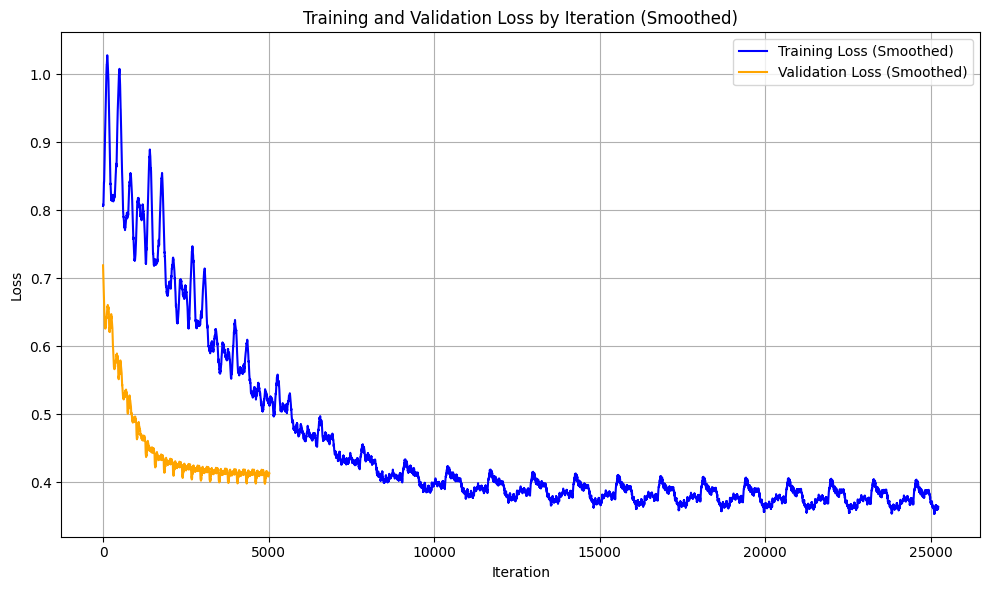

In [10]:
# Plot losses by iteration
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smooth the losses
window_size = 500  # Adjust based on desired smoothing
smoothed_train_losses = moving_average(train_iteration_losses, window_size)
smoothed_val_losses = moving_average(val_iteration_losses, window_size)

# Adjust x-axis for smoothed curves
train_x = np.arange(len(smoothed_train_losses))
val_x = np.arange(len(smoothed_val_losses))

# Plot original and smoothed losses
plt.figure(figsize=(10, 6))

# Original loss curves
# plt.plot(train_iteration_losses, label="Training Loss (Original)", alpha=0.3, color="blue")
# plt.plot(val_iteration_losses, label="Validation Loss (Original)", alpha=0.3, color="orange")

# Smoothed loss curves
plt.plot(train_x, smoothed_train_losses, label="Training Loss (Smoothed)", color="blue")
plt.plot(val_x, smoothed_val_losses, label="Validation Loss (Smoothed)", color="orange")

# Formatting
plt.title("Training and Validation Loss by Iteration (Smoothed)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluate

In [11]:
@torch.no_grad()
def evaluate_test_set(model, test_indices, window_in=14, horizon=7):
    model.eval()
    astgcn_preds, naive_preds, gts = [], [], []
    
    for t in test_indices:
        if t < window_in:
            continue
        
        # Ground truth
        data = dataset[t]
        y_true = data.y  # => [N, 6, 7]
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.cpu().numpy()
        gts.append(y_true.reshape(-1))  # flatten
        
        # ASTGCN
        x_stack = []
        for past_t in range(t - window_in, t):
            x_in = dataset[past_t].x
            if isinstance(x_in, torch.Tensor):
                x_in = x_in.cpu().numpy()
            x_stack.append(x_in)
        x_stack = np.stack(x_stack, axis=-1)  # => [N, 6, 14]
        
        x_torch = torch.from_numpy(x_stack).float().to(device).unsqueeze(0)
        e_idx = data.edge_index.to(device)
        
        y_pred_astgcn = model(x_torch, e_idx).squeeze(0).cpu().numpy()  # => [N, 6, 7]
        astgcn_preds.append(y_pred_astgcn.reshape(-1))
        
        # Naive => "Use yesterday's snapshot repeated for 7 days"
        if t-1 >= 0:
            naive_day = dataset[t-1].x  # => [N, 6]
            if isinstance(naive_day, torch.Tensor):
                naive_day = naive_day.cpu().numpy()
            # expand to => [N, 6, 7]
            naive_7day = np.repeat(naive_day[..., None], horizon, axis=-1)
            naive_preds.append(naive_7day.reshape(-1))
        else:
            # skip if no previous day
            # or set some default approach
            continue

    astgcn_preds = np.concatenate(astgcn_preds, axis=0)
    naive_preds  = np.concatenate(naive_preds, axis=0)
    gts          = np.concatenate(gts, axis=0)
    
    # Compute metrics
    def metrics_dict(yhat, y):
        mse  = root_mean_squared_error(y, yhat)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y, yhat)
        r2   = r2_score(y, yhat)
        return {"MSE":mse, "RMSE":rmse, "MAE":mae, "R2":r2}
    
    results = {
        "ASTGCN": metrics_dict(astgcn_preds, gts),
        "Naive":  metrics_dict(naive_preds,  gts),
    }
    return results

test_results = evaluate_test_set(model_wrapper, test_indices, window_in=WINDOW_IN, horizon=HORIZON)
print("===== Test Results =====")
for model_name, metrics in test_results.items():
    print(f"{model_name} metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")
    print("")


===== Test Results =====
ASTGCN metrics:
  MSE: 0.6395
  RMSE: 0.7997
  MAE: 0.3765
  R2: 0.5050

Naive metrics:
  MSE: 0.8053
  RMSE: 0.8974
  MAE: 0.3244
  R2: 0.2150



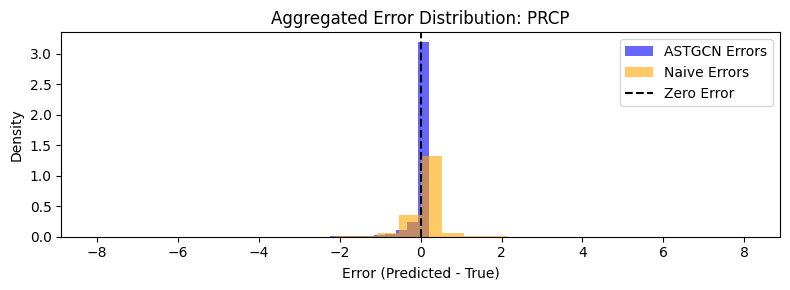

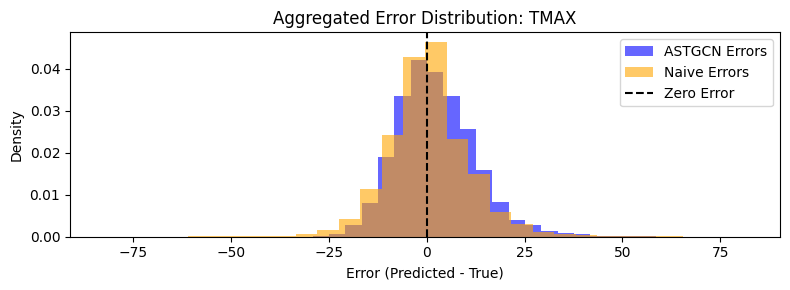

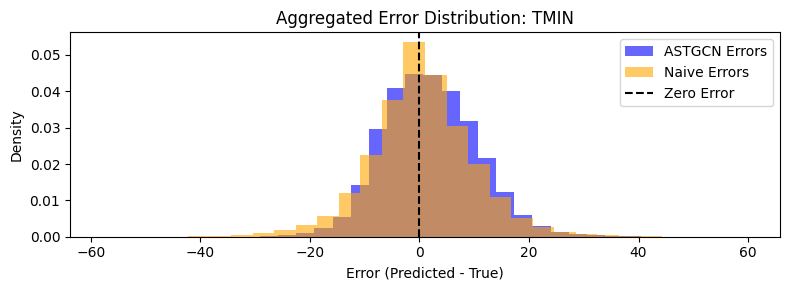

In [19]:
def inverse_transform_3D(scaled_3D, scaler):
    """
    scaled_3D: shape [N, 6, H]
    We'll assume we only want to inverse-transform the first 5 features,
    leaving the day_of_year fraction alone.
    """
    N, F, H = scaled_3D.shape
    
    # Separate weather vs. day_of_year
    scaled_weather = scaled_3D[:, :3, :]  # => [N, 5, H]
    day_of_year    = scaled_3D[:, 3:, :]  # => [N, 1, H]
    
    # Flatten weather => [N*H, 5]
    reshaped = scaled_weather.transpose(0,2,1).reshape(-1, 3)
    inv = scaler.inverse_transform(reshaped)  # => [N*H, 5]
    inv = inv.reshape(N, H, 3).transpose(0,2,1)  # => [N, 5, H]
    
    # Re-combine with day_of_year
    out = np.concatenate([inv, day_of_year], axis=1)  # => [N, 6, H]
    return out

def plot_aggregated_error_distributions(test_indices, model, scaler, window_in=14, horizon=7,
    feat_names = ['PRCP', 'TMAX', 'TMIN']):
    """
    Aggregate errors across all test time steps and plot the error distributions
    for ASTGCN and Naïve models for each feature.
    """
    astgcn_errors_all = []
    naive_errors_all = []
    
    for t in test_indices:
        if t < window_in:
            continue
        
        # Ground truth
        data = dataset[t]
        y_true = data.y  # Ground truth => [N, 6, 7]
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.cpu().numpy()

        # ASTGCN forecast
        x_stack = []
        for past_t in range(t - window_in, t):
            x_in = dataset[past_t].x
            if isinstance(x_in, torch.Tensor):
                x_in = x_in.cpu().numpy()
            x_stack.append(x_in)
        x_stack = np.stack(x_stack, axis=-1)  # => [N, 6, 14]

        x_torch = torch.from_numpy(x_stack).float().to(device).unsqueeze(0)  # => [1, N, 6, 14]
        e_idx = data.edge_index.to(device)
        with torch.no_grad():
            y_pred_astgcn = model(x_torch, e_idx).squeeze(0).cpu().numpy()  # => [N, 6, 7]

        # Naïve forecast
        naive_day = dataset[t - 1].x  # => [N, 6]
        if isinstance(naive_day, torch.Tensor):
            naive_day = naive_day.cpu().numpy()
        y_pred_naive = np.repeat(naive_day[..., None], horizon, axis=-1)  # => [N, 6, 7]

        # Inverse-transform
        y_true_inv       = inverse_transform_3D(y_true, scaler)       # [N, 6, 7]
        y_astgcn_inv     = inverse_transform_3D(y_pred_astgcn, scaler)  # [N, 6, 7]
        y_naive_inv      = inverse_transform_3D(y_pred_naive, scaler)   # [N, 6, 7]

        # Compute errors
        astgcn_errors = y_astgcn_inv - y_true_inv  # [N, 6, 7]
        naive_errors = y_naive_inv - y_true_inv    # [N, 6, 7]

        # Reshape errors to [N * H, F] for aggregation
        astgcn_errors_flat = astgcn_errors.transpose(0, 2, 1).reshape(-1, 4)  # [N*H, 6]
        naive_errors_flat = naive_errors.transpose(0, 2, 1).reshape(-1, 4)    # [N*H, 6]

        # Accumulate errors across all test steps
        astgcn_errors_all.append(astgcn_errors_flat)
        naive_errors_all.append(naive_errors_flat)

    # Concatenate all errors across test steps
    astgcn_errors_all = np.concatenate(astgcn_errors_all, axis=0)  # [total_samples, 6]
    naive_errors_all = np.concatenate(naive_errors_all, axis=0)    # [total_samples, 6]

    # Plot error distributions for each feature
    # feat_names = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']
    for f_idx, feat in enumerate(feat_names):
        plt.figure(figsize=(8, 3))
        plt.hist(
            astgcn_errors_all[:, f_idx],
            bins=30,
            alpha=0.6,
            label='ASTGCN Errors',
            color='blue',
            density=True,
        )
        plt.hist(
            naive_errors_all[:, f_idx],
            bins=30,
            alpha=0.6,
            label='Naive Errors',
            color='orange',
            density=True,
        )
        plt.axvline(0, color='black', linestyle='--', label='Zero Error')
        plt.title(f"Aggregated Error Distribution: {feat}")
        plt.xlabel("Error (Predicted - True)")
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_aggregated_error_distributions(test_indices, model_wrapper, scaler, window_in=WINDOW_IN, horizon=HORIZON)